# CNN Text Classifier revisited - data balancing and augmentation

by Michael Hunziker

## Summary
The aim of this notebook is apply data balancing and augmentation for the use in our CNN Text Classifier, with the hope to improve the poor performance for our limited dataset.

In notebook 05 for the use with the transformer model, we reduced the negative tweets to balance the dataset. This works, probably because we don't need that many samples anyway. I suspected this will not work here and indeed it didn't. let's try to augment our data.


*   Prepare Dataset
*   Extract the vocabulary
*   Use Keras TextVectorization layer for text vectorysation
*   Use fasttext for the word embeddings
*   Build a CNN model
*   Evaluate and improve the model


</br>

<a href="https://colab.research.google.com/github/miam-bonbon/assignment-adv-nlp/blob/main/adv_nlp_assignment_mh_05b_CNN_text_classifier_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's do some imports

In [1]:
%%capture

!pip install 'fhnw-nlp-utils>=0.9.8,<0.10.0'

from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.system import set_log_level
from fhnw.nlp.utils.colab import runs_on_colab

# should prevent verbose logging
set_log_level(2)

import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
from fhnw.nlp.utils.system import system_info
print(system_info())

OS name: posix
Platform name: Linux
Platform release: 6.1.85+
Python version: 3.10.12
CPU brand: Intel(R) Xeon(R) CPU @ 2.20GHz
CPU cores: 1
RAM: 12.67GB total and 11.36GB available
Tensorflow version: 2.17.1
GPU is available


In [3]:
# create a DEV variable to use later
DEV = False

In [4]:
%%time

!rm "./data/COVIDSenti_tokenized_02.parq"

download("https://github.com/miam-bonbon/assignment-adv-nlp/raw/refs/heads/main/data/COVIDSenti_tokenized_02.parq", "data/COVIDSenti_tokenized_02.parq")
data = load_dataframe("data/COVIDSenti_tokenized_02.parq")
data.shape

rm: cannot remove './data/COVIDSenti_tokenized_02.parq': No such file or directory
CPU times: user 594 ms, sys: 102 ms, total: 696 ms
Wall time: 2.07 s


(22516, 8)

Again - we need text, not tokens

In [5]:
import pandas as pd

def list_to_string(tokens):
    """Converts a list of tokens to a single string."""
    return " ".join(tokens)

# Apply the function to each element of the column and create a new column
data['token_clean_tweet_tokenized_text'] = data['token_clean_tweet_tokenize'].apply(list_to_string)

In [6]:
data = data[['token_clean_tweet_tokenized_text', 'label']]

In [7]:
data.head(3)

,token_clean_tweet_tokenized_text,label
2,"tldr : sars , possibly new coronavirus . diffi...",neg
8,#ccp keep saying unknown cause pneumonia ? cau...,neg
11,always feel weird hoping another coronavirus o...,neg


In [8]:
# check label distribution again
print(data['label'].value_counts())

label
neg    16273
pos     6243
Name: count, dtype: int64


In [9]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.4 MB/s eta 0:00:00


In [14]:
# check label distribution again

print(data['label'].value_counts())

label
neg    16273
pos     6243
Name: count, dtype: int64


## Data augmentation

We use nlpaug augmenter to generate augmented tweets and balance the dataset

In [15]:
import nlpaug.augmenter.word as naw
import random # Import the random module
import re

import nltk
nltk.download('averaged_perceptron_tagger_eng')

from tqdm import tqdm

# Filter for positive examples
positive_examples = data[data['label'] == 'pos']['token_clean_tweet_tokenized_text'].tolist()

# aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', aug_p=0.7)

# # Initialize the SynonymAug augmenter
aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.7)

# Generate 10,000 new positive tweets
augmented_positive_examples = []
original_tweets = [] # List to store original tweets
for _ in tqdm(range(10000)):
  # print(len(augmented_positive_examples))
  # Randomly select a positive example to augment
  example = random.choice(positive_examples)
  # Apply synonym replacement augmentation
  augmented_example = aug.augment(example)
  # we have a list
  augmented_example = augmented_example[0]
  augmented_positive_examples.append(augmented_example)
  original_tweets.append(example) # Store the original tweet

# Create a new DataFrame for augmented positive examples
augmented_positive_df = pd.DataFrame({
    'token_clean_tweet_tokenized_text': augmented_positive_examples,
    'label': 'pos',
    'augmented': 'True',
    'original_tweet': original_tweets, # Add the original tweet column
})

# Concatenate with original data
balanced_data = pd.concat([data, augmented_positive_df], ignore_index=True)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
100%|██████████| 10000/10000 [00:14<00:00, 673.03it/s]


In [16]:
# check label distribution again

print(balanced_data['label'].value_counts())

label
neg    16273
pos    16243
Name: count, dtype: int64


In [17]:
# Display a few examples where 'augmented' is True
balanced_data[balanced_data['augmented'] == 'True'].head()

,token_clean_tweet_tokenized_text,label,augmented,original_tweet
22516,believe many contacts church phone number affi...,pos,True,believe many contacts church number confirmed ...
22517,"bit covid - instance unaltered, say wellness m...",pos,True,"number covid - cases unchanged , says health m..."
22518,frankly remember besides # coronavirus make gr...,pos,True,honestly think besides #coronavirus causes flu...
22519,"fast signature tune: enunciate ""! "" monopoly c...",pos,True,"quick signature : say "" ! "" monopoly coronavir..."
22520,cornet: beautiful coronavirus exam kits anyone...,pos,True,trump : beautiful coronavirus test kits anyone...


In [20]:
# Split data into training and validation sets, ensuring augmented data only in training.
from sklearn.model_selection import train_test_split

source_data = balanced_data[balanced_data['augmented'] != 'True'] # validation set should be originally not augmented
augmented_data = balanced_data[balanced_data['augmented'] == 'True']

# Now we balance the source data
# source_data = balance_data(source_data)
# print(source_data['label'].value_counts())

# And split our validation data from it
X_train_source, X_test, y_train_source, y_test = train_test_split(
    source_data['token_clean_tweet_tokenized_text'],
    source_data['label'].map({'pos': 1, 'neg': 0}),
    test_size=0.2, # Example: 20% for testing
    random_state=43  # For reproducibility
)
print(len(X_train_source), len(X_test), len(y_train_source), len(y_test))

# Now we get our augmented training data
X_train_augmented, y_train_augmented = (
    augmented_data['token_clean_tweet_tokenized_text'],
    augmented_data['label'].map({'pos': 1, 'neg': 0})
)
print(len(X_train_augmented), len(y_train_augmented))

# And combine to the real training data
X_train = pd.concat([X_train_source, X_train_augmented], ignore_index=True)
y_train = pd.concat([y_train_source, y_train_augmented], ignore_index=True)
print(len(X_train), len(y_train))

X_train.head(), y_train.head()

18012 4504 18012 4504
10000 10000
28012 28012


(0    largest north american housewares trade show c...
 1    oups another #freakout ! #trump #fail realdona...
 2    another symptoms coronavirus think arsenal man...
 3    flight monday got cancelled due novel coronavi...
 4    china coronavirus : people uk tested new strai...
 Name: token_clean_tweet_tokenized_text, dtype: object,
 0    0
 1    0
 2    1
 3    0
 4    0
 Name: label, dtype: int64)

Let's test this in a standard CNN for binary classification please and make sure, we use positive tweets with augmented=True only in the training data, never in the validation data

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model = ""

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000) # Example vocab size
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = 80 # Example max sequence length - we use padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

# Build CNN model
inputs = tf.keras.Input(shape=(max_length,)) # Define input layer
embedding_layer = Embedding(5000, 100)(inputs) # Embedding layer
conv_layer = Conv1D(64, 5, activation='relu')(embedding_layer) # Convolutional layer
pooling_layer = MaxPooling1D(pool_size=4)(conv_layer) # Max pooling layer
flatten_layer = Flatten()(pooling_layer) # Flatten layer
dropout_layer = Dropout(0.5)(flatten_layer) # Add a dropout layer after the flatten layer
outputs = Dense(1, activation='sigmoid')(flatten_layer) # Output layer

# Create the model object
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() # Now you should see the model summary

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 80, 100)             │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 76, 64)              │          32,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 19, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,217 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 533,281 (2.03 MB)

 Trainable params: 533,281 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train model
history = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=10, batch_size=32) # Example epochs and batch size

Epoch 1/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.7960 - loss: 0.3713 - val_accuracy: 0.9307 - val_loss: 0.1656
Epoch 2/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9704 - loss: 0.0790 - val_accuracy: 0.9321 - val_loss: 0.1672
Epoch 3/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9842 - loss: 0.0493 - val_accuracy: 0.9265 - val_loss: 0.2212
Epoch 4/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9917 - loss: 0.0269 - val_accuracy: 0.9274 - val_loss: 0.2293
Epoch 5/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9970 - loss: 0.0121 - val_accuracy: 0.9263 - val_loss: 0.2868
Epoch 6/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9981 - loss: 0.0063 - val_accuracy: 0.9230 - val_loss: 0.3007
Epoch 7/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9986 - loss: 0.0042 - val_accuracy: 0.9225 - val_loss: 0.3602
Epoch 8/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9988 - loss: 0.0033 - val_accuracy:

In [23]:
from fhnw.nlp.utils.ploting import plot_history
from fhnw.nlp.utils.ploting import report_classification_results

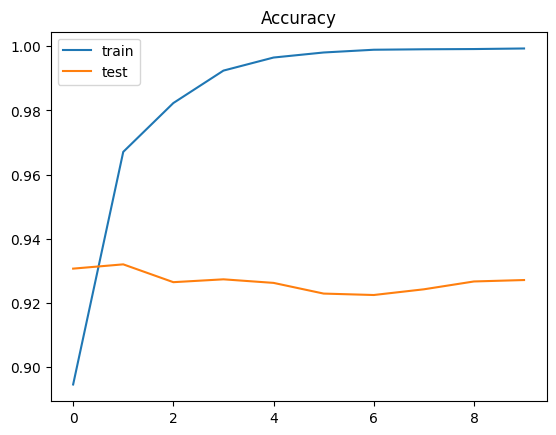

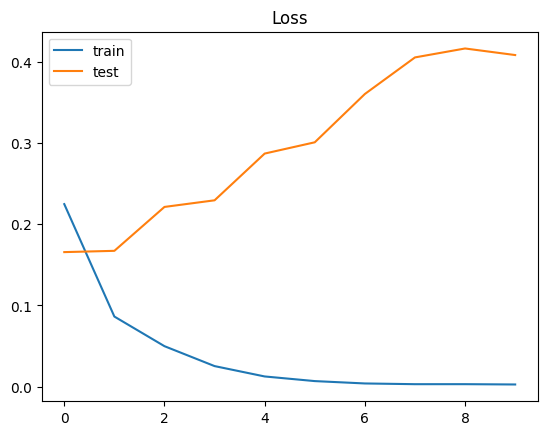

In [24]:
plot_history(history)

Still overfitting - let's reduce embedding dimensionality, number of filters, a regularizer, increase dropout rate and use early stopping

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers

model = ""

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000) # Example vocab size
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = 80 # Example max sequence length - we use padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

# Build CNN model
inputs = tf.keras.Input(shape=(max_length,)) # Define input layer
embedding_layer = Embedding(5000, 50)(inputs) # Reduced embedding dimensionality
# Reduced number of filters and regularizer
conv_layer = Conv1D(32, 5, activation='relu', kernel_regularizer=regularizers.l2(0.01))(embedding_layer)
pooling_layer = MaxPooling1D(pool_size=4)(conv_layer) # Max pooling layer
flatten_layer = Flatten()(pooling_layer) # Flatten layer
dropout_layer = Dropout(0.7)(flatten_layer) # Increased dropout rate
# Regularizer
outputs = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(flatten_layer)

# Create the model object
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() # Now you should see the model summary

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 80, 50)              │         250,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 76, 32)              │           8,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 19, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 608)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             609 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 258,641 (1010.32 KB)

 Trainable params: 258,641 (1010.32 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

# Stop if val_accuracy doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test),
                    epochs=55, batch_size=32, callbacks=[early_stopping])

Epoch 1/55
876/876 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6661 - loss: 0.6416 - val_accuracy: 0.9194 - val_loss: 0.3119
Epoch 2/55
876/876 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9570 - loss: 0.2347 - val_accuracy: 0.9336 - val_loss: 0.2590
Epoch 3/55
876/876 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9677 - loss: 0.1947 - val_accuracy: 0.9210 - val_loss: 0.2747
Epoch 4/55
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9726 - loss: 0.1747 - val_accuracy: 0.9292 - val_loss: 0.2503
Epoch 5/55
876/876 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9761 - loss: 0.1612 - val_accuracy: 0.9294 - val_loss: 0.2478


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      3267
           1       0.87      0.90      0.88      1237

    accuracy                           0.93      4504
   macro avg       0.91      0.92      0.92      4504
weighted avg       0.93      0.93      0.93      4504



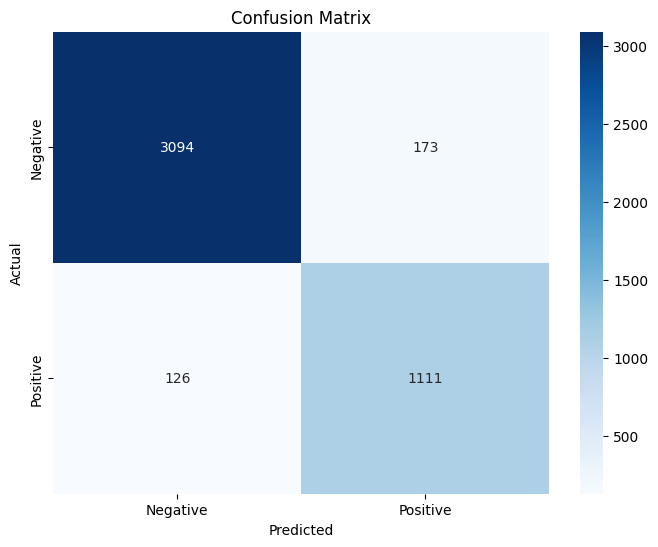

In [27]:
# plot classification results

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the test set
y_pred = model.predict(X_test_pad)
y_pred_classes = (y_pred > 0.5).astype(int)

# Classification Report
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Check performance on all data.

1017/1017 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9572 - loss: 0.2212
Accuracy on combined dataset: [0.20442938804626465, 0.9656169414520264]
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     16273
           1       0.97      0.96      0.97     16243

    accuracy                           0.97     32516
   macro avg       0.97      0.97      0.97     32516
weighted avg       0.97      0.97      0.97     32516



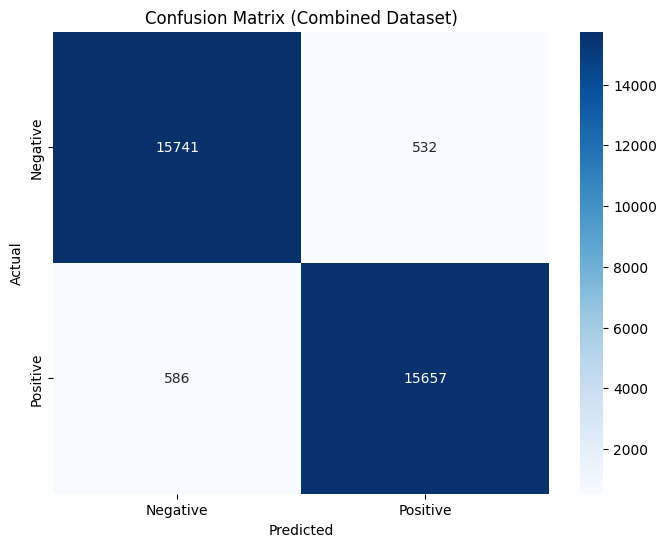

In [28]:
# Evaluate on the combined dataset (original data + augmented data)
# Note: Since the augmentation is already done, we use the balanced_data
X_combined = balanced_data['token_clean_tweet_tokenized_text']
y_combined = balanced_data['label'].map({'pos': 1, 'neg': 0})

# Tokenize and pad sequences for the combined dataset
X_combined_seq = tokenizer.texts_to_sequences(X_combined)
X_combined_pad = pad_sequences(X_combined_seq, maxlen=max_length)

# Evaluate the model on the combined data
combined_accuracy = model.evaluate(X_combined_pad, y_combined)

print(f"Accuracy on combined dataset: {combined_accuracy}")


from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the combined dataset
y_combined_pred = model.predict(X_combined_pad)
y_combined_pred_classes = (y_combined_pred > 0.5).astype(int)

# Classification Report for the combined dataset
print(classification_report(y_combined, y_combined_pred_classes))

# Confusion Matrix for the combined dataset
cm_combined = confusion_matrix(y_combined, y_combined_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_combined, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Combined Dataset)')
plt.show()

# Conclusion

The performance on the test set is still not at par, even with data augmentation. I conclude we would have to use a dataset that is bigger.<br/>
It's not satisfying for me to not get to a better outcome. But the lesson learned here is to pay more attention to the size of the dataset, if we have the task to train a CNN from the ground.